# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением accuracy. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверим accuracy на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Откройте и изучите файл

### Откроем файл и сохраним датафрейм в переменную `df`

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Исследуем данные

 Выведем основную информацию для датафрейма `df` с помощью метода `info()`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Так как колонки с признаками `calls` (количество звонков) и `messages` (количество сообщений) содержат целые значения данные столбцы необходимо привести к типу `'int'`.

In [4]:
df[['calls', 'messages']]=df[['calls', 'messages']].astype(int)
# приведем значения по столбцу mb_used к порядку значений (масштабируем) по остальным столбцам для обучения моделей,
# где важен вес признака (например модель ближайших соседей или логистической регрессии)
df['mb_used'] = df['mb_used'] / 100
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [5]:
# проверим числовые значения на отсутствие/присутствие аномалий в данных (напрмер отрицательных значений)
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,172.076738,0.306472
std,33.236368,234.569872,36.148326,75.709682,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,124.919025,0.000000
50%,62.000000,430.600000,30.000000,169.432350,0.000000
75%,82.000000,571.927500,57.000000,214.247000,1.000000
max,244.000000,1632.060000,224.000000,497.457300,1.000000


Аномальных значений в данных нет.

Для определения адекватности построенных моделей можно рассмотреть наличие линейной зависимости между признаками (построить матрицу коэф. корреляции Пирсона).

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Сильная положительная связь наблюдается между признаками `calls` и `minutes`. Это вполне логично, так как чем чаще клиент совершает звонки, тем больше расходует минут.

Так же хорошая корреляция наблюдается между признаками `calls` и `mb_used`, `minutes` и `mb_used`. Возможно те клиенты, которые чаще совершают звонки, чаще используют интернет, т.е. являются более активными клиентами. 

По остальным признакам наблюдается достаточная связь в районе значений 0.17-0.20.

Построим распределения для всех признаков.

<Figure size 1080x648 with 0 Axes>

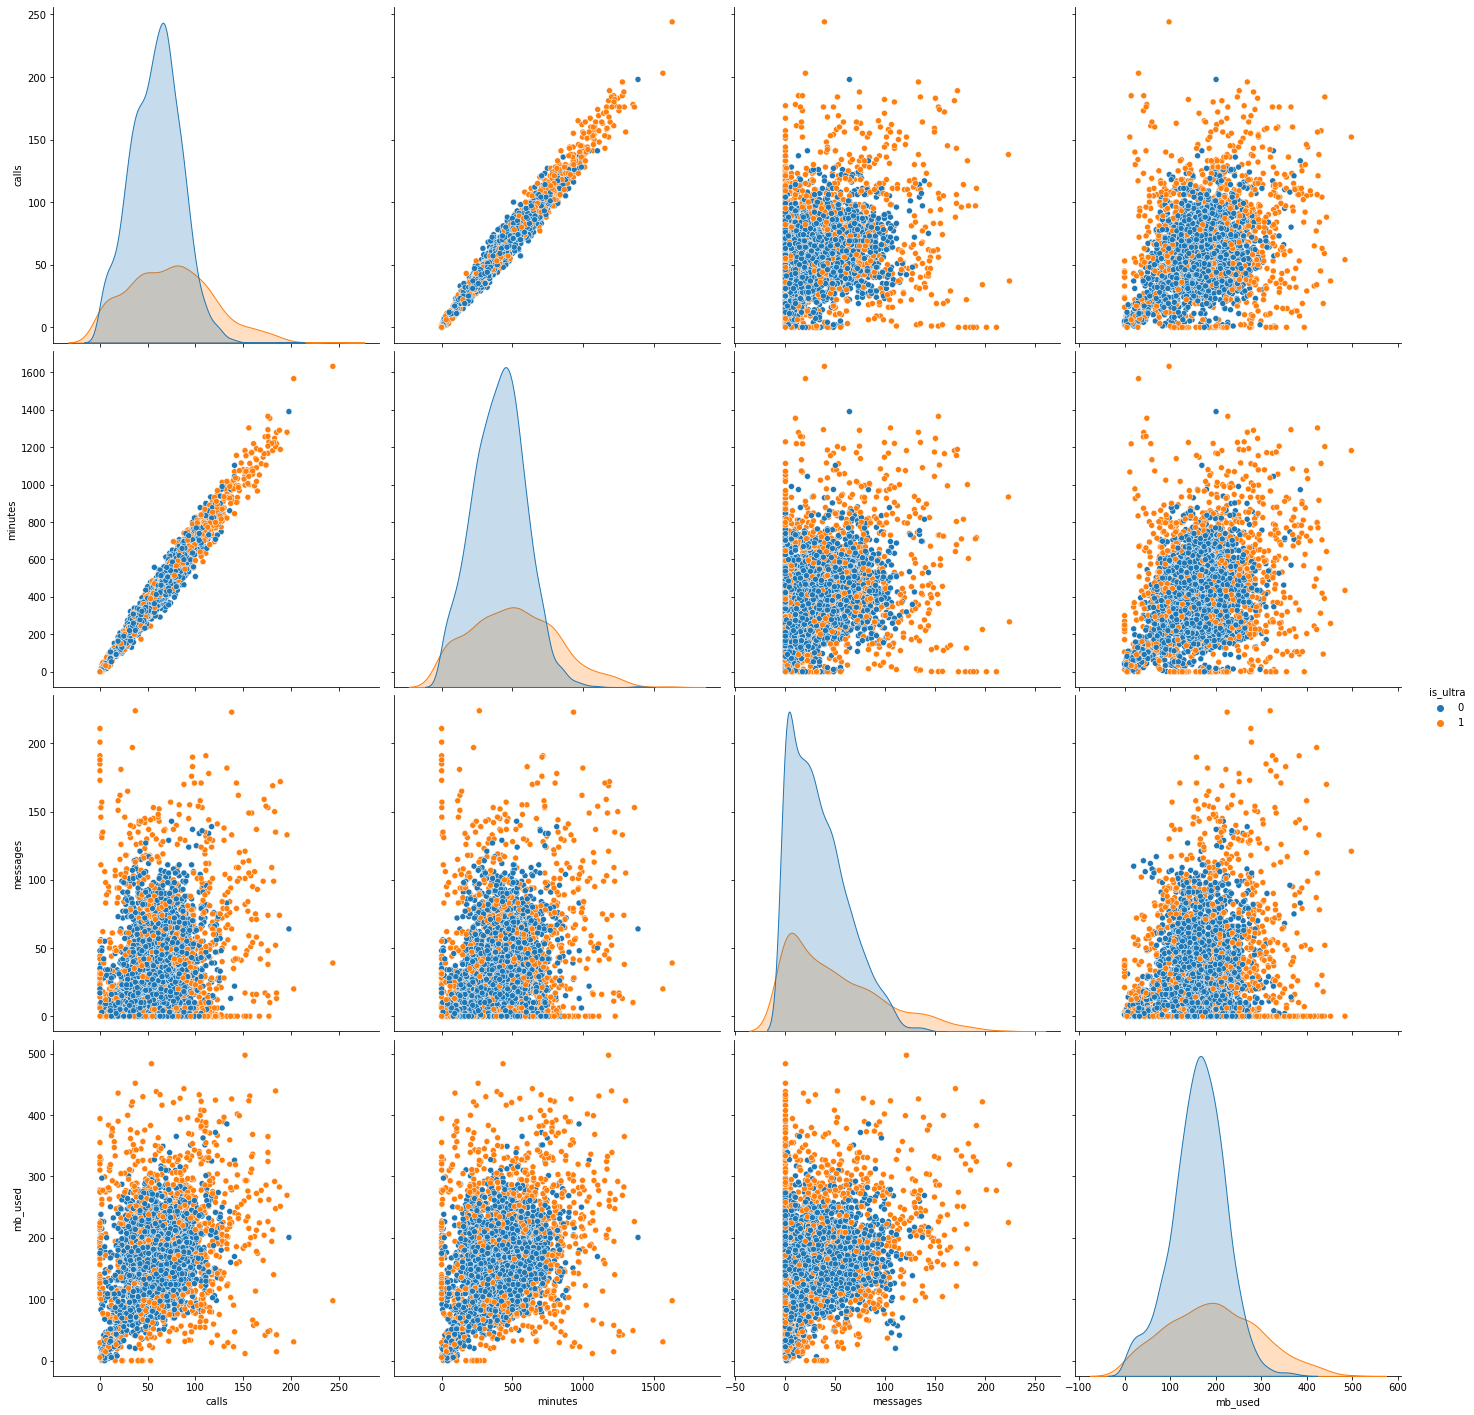

In [7]:
plt.figure(figsize=(15, 9))
sns.pairplot(df, hue='is_ultra', height=5);

Признаки `calls`, `minutes` и `mb_used` для двух групп клиентов иммеют близкое к нормальному распределение. Очевидно что клиентов с тарифом *`smart`* в исходных данных больше. Так же отмечается не явное, но всё-таки различимое отличие в распределении признаков для двух групп. Более активные клиенты, тратящие больше трафика, чаще имеют тариф  *`ultra`*. Но зная основные предложения тарифа *`ultra`* уже можно сделать предварительный вывод о его избыточности для многих клиентов. Можно сделать предположение о том, что люди, имеющие тариф *`smart`*, не готовы перейти на столь дорогой тариф *`ultra`* с избыточными для них лимитами. 

Далее можно проверить зависимость двух групп клиентов (с тарифом `ультра` и тарифом `smart`) от признаков `mb_used`, `minutes` и `messages` с помощью построения boxplot-ов.

<AxesSubplot:xlabel='is_ultra', ylabel='messages'>

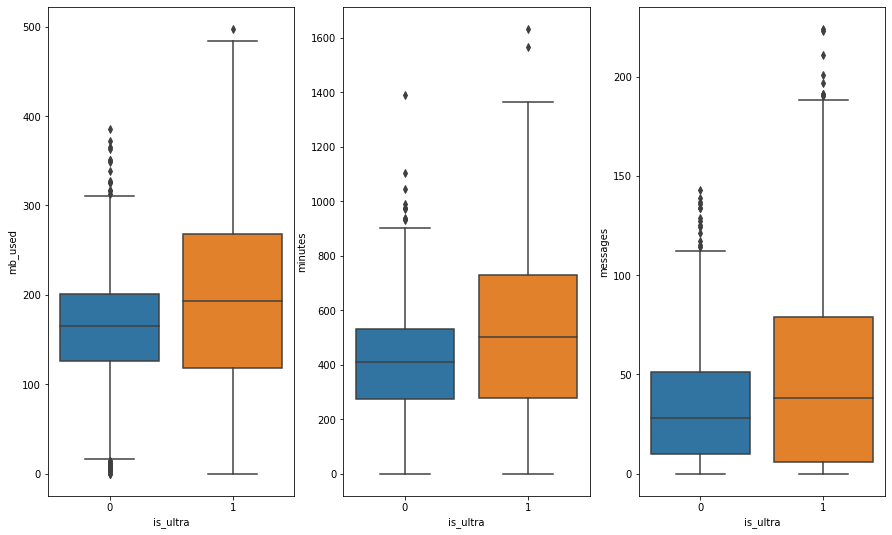

In [8]:
_, axes = plt.subplots(1, 3, figsize=(15, 9))
sns.boxplot(x='is_ultra', y='mb_used', data=df, ax=axes[0])
sns.boxplot(x='is_ultra', y='minutes', data=df, ax=axes[1])
sns.boxplot(x='is_ultra', y='messages', data=df, ax=axes[2])

*Вывод*: большая часть клиентов (медианное значение) находящихся на тарифе `ultra` чаще совершают звонки, пишут сообщения и используют интернет, а значит более активны. Таким образом можно предположить что более активные клиенты чаще выбирают для себя тариф `ultra`. Данную информацию можно использовать для определния адекватности обученных моделей.

## Разбейте данные на выборки

В связи с тем, что в исходных данных отдельной тестовой выборки нет, данные необходимо разбить на обучающую, валидационную и тестовую выборку в соотношении 3:1:1 (60%, 20%, 20%).

In [9]:
df_train, df_test_valid = train_test_split(df, test_size=0.4, random_state=123, stratify=df['is_ultra'])
df_test, df_valid = train_test_split(df_test_valid, test_size=0.5, random_state=123, stratify=df_test_valid['is_ultra'])

# так же для лучшего качества обучения моделей на кросс-валидации и дообучения 
# лучшей модели перед тестовой выборкой объединим обучающую и валидационную выборку

df_train_valid = pd.concat([df_train, df_valid], axis=0)
df_train_valid

,calls,minutes,messages,mb_used,is_ultra
2688,57,371.55,16,122.8346,0
1176,69,524.30,47,146.8459,0
1355,72,495.11,34,158.8737,0
2961,137,899.90,0,102.8926,1
2367,52,301.04,7,116.6203,1
...,...,...,...,...,...
1584,27,192.57,105,237.4670,1
398,85,527.02,4,143.6842,0
2799,65,489.56,74,194.3757,1
1765,42,268.56,0,193.0379,0


In [10]:
# проверка соответствия размерности после разбиения на выборки 
df_train.shape, df_test_valid.shape, df_test.shape, df_valid.shape

((1928, 5), (1286, 5), (643, 5), (643, 5))

Далее необходимо разграничить признаки и целевой признак, создав новые переменные.

In [11]:
# для обучающей выборки
feat_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

# для обобщенной выборки тест и валид
# feat_test_valid = df_test_valid.drop(['is_ultra'], axis=1)
# target_test_valid = df_test_valid['is_ultra']

# для тестовой выборки 
feat_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

# для валид выборки 
feat_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

# для обобщенной обучающей и валид выборки
feat_train_valid = df_train_valid.drop(['is_ultra'], axis=1)
target_train_valid = df_train_valid['is_ultra']

In [12]:
df_test['is_ultra'].value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

In [13]:
df_valid['is_ultra'].value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

## Исследуйте модели

### Решающее дерево

Для начала попробуем обучить модель решающего дерево с перебором двух гиперпараметров:
- критерий (`Джини`, `энтропия`);
- максимальная глубина дерева (`max_depth`).
Так как изначально в данных совсем немного признаков (4) менять гиперпараметр `max_features` нет никакого смысла. 

In [14]:
%%time 

# инициализируем перемнную для лучшей оценки
best_result_tree = 0 

# подберем лучшие гиперпараметры в цикле в определенном диапазоне значений
for crit_ in ['gini', 'entropy']: 
    for depth_ in range(1, 11):
        model_tree = DecisionTreeClassifier(criterion=crit_, max_depth=depth_, random_state=123)
        model_tree.fit(feat_train, target_train)
        predictions_valid = model_tree.predict(feat_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        
        # запишем в переменные гиперпараметры лучшей модели и саму модель
        if accuracy > best_result_tree:
            best_result_tree = accuracy
            depth = depth_
            critery = crit_
            best_model_tree = model_tree

# выведем результаты
print('critery: ', critery)
print('max_depth: ', depth)
print('accuracy: ', best_result_tree)

critery:  entropy
max_depth:  6
accuracy:  0.8149300155520995
CPU times: user 132 ms, sys: 106 µs, total: 132 ms
Wall time: 131 ms


Процент правильных ответов на валидационной выборке лучшей модели (с `критерием` **энтропия**, максимальной `глубиной дерева` - **6**) составил **81,5%**. Скорость выполнения - **131 мс**.

Для более полного исследования применим в обучении модели кросс-валидацию с подбором тех же гиперпараметров.

In [15]:
%%time

# определим диапазоны значений гиперпараметров для кросс-валидации
tree_params = {'max_depth': range(1,4),'criterion': ['gini', 'entropy']}

# обучим модель с использованием кросс-валидации
model_tree_cs = DecisionTreeClassifier(random_state=123)
tree_grid = GridSearchCV(model_tree, tree_params, n_jobs=-1)
tree_grid.fit(feat_train_valid, target_train_valid)

# выведем на экран результаты
print(tree_grid.best_params_)
print(tree_grid.best_score_)

{'criterion': 'gini', 'max_depth': 3}
0.7946311057383552
CPU times: user 173 ms, sys: 103 µs, total: 173 ms
Wall time: 181 ms


Процент правильных ответов на валидационной выборке лучшей модели с применением `кросс-валидации` (с `критерием` **Джини**, максимальной `глубиной дерева` - **3**) составил **79,4%**. Скорость выполнения - **181 мс**.

### Случайный лес

Обучим модель с использованием `случайного леса` с подбором следующих гиперпараметров:
- критерий (`Джини`, `энтропия`);
- максимальная глубина дерева (`max_depth`);
- количество деревьев в лесу (`n_estimators`).

In [16]:
%%time

# инициализируем перемнную для лучшей оценки
best_result = 0

# подберем лучшие гиперпараметры в цикле в определенном диапазоне значений
for crit_ in ['gini', 'entropy']:
    for depth_ in range(1, 11):
        for est_ in range(1, 35):
            model_rand_forest = RandomForestClassifier(random_state=123, criterion=crit_, \
                                                       max_depth=depth_, n_estimators=est_, n_jobs=-1)
            model_rand_forest.fit(feat_train, target_train)
            result = model_rand_forest.score(feat_valid, target_valid)
            
            # запишем в переменные гиперпараметры лучшей модели
            if result > best_result:
                best_result = result
                depth = depth_
                critery_rf = crit_
                est = est_
                best_model_rand_forest = model_rand_forest

# выведем на экран результаты
print('critery: ', critery_rf)
print('max_depth: ', depth)
print('estimators: ', est)
print('accuracy: ', best_result)

critery:  entropy
max_depth:  9
estimators:  18
accuracy:  0.833592534992224
CPU times: user 32.7 s, sys: 307 ms, total: 33 s
Wall time: 33 s


Процент правильных ответов на валидационной выборке лучшей модели (с `критерием` **энтропия**, максимальной `глубиной дерева` - **6**, `количеством деревьев` - **18**) составил **83,3%**. Скорость выполнения - **33 с**.

Применим в обучении модели кросс-валидацию с подбором тех же гиперпараметров.

In [17]:
%%time

# определим диапазоны значений гиперпараметров для кросс-валидации
rf_params = {'max_depth': range(1,11),'criterion': ['gini', 'entropy'], 'n_estimators': range(1,35)}

# обучим модель с использованием кросс-валидации
model_rf_cs = RandomForestClassifier(random_state=123)
rf_grid = GridSearchCV(model_rf_cs, rf_params, n_jobs=-1)
rf_grid.fit(feat_train_valid, target_train_valid)

# выведем на экран результаты
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 17}
0.814468663820785
CPU times: user 2min 50s, sys: 901 ms, total: 2min 51s
Wall time: 2min 51s


Процент правильных ответов на валидационной выборке лучшей модели (с `критерием` **энтропия**, максимальной `глубиной дерева` - **10**, `количеством деревьев` - **17**) составил **81,4%**. Скорость выполнения - **2 мин. 51 с**.

### Модель ближайших соседей - kNN.

Обучим модель с использованием `метода ближайших соседей` с подбором следующих гиперпараметров:
- метрики (`minkowski`, `minkowski`, `euclidean`, `chebyshev`);
- влияние веса (`uniform`, `distance`);
- алгоритм (`brute`, `ball_tree`, `kd_tree`);
- количество соседей `n_neighbors`.

In [18]:
%%time

# инициализируем перемнную для лучшей оценки
best_result_knn = 0

# подберем лучшие гиперпараметры в цикле в определенном диапазоне значений
for metric_ in ['minkowski', 'minkowski', 'euclidean', 'chebyshev']:
    for weights_ in ['uniform', 'distance']:
        for alg_ in ['brute', 'ball_tree', 'kd_tree']:
            for neigh_ in range(1, 30):
                model_knn = KNeighborsClassifier(n_neighbors=neigh_, metric=metric_, \
                                                 weights=weights_, algorithm=alg_, n_jobs=-1)
                model_knn.fit(feat_train, target_train)
                knn_pred = model_knn.predict(feat_valid)
                result = accuracy_score(target_valid, knn_pred)
                
                # запишем в переменные гиперпараметры лучшей модели
                if result > best_result_knn:
                    best_result_knn = result
                    neighbors = neigh_
                    res_metric = metric_
                    res_weights = weights_
                    res_algoritm = alg_
                    best_model_knn = model_knn
                    
# выведем на экран результаты
print('Neighbors', neighbors)
print('Metric', res_metric)
print('Weights', res_weights)
print('Algoritm', res_algoritm)
print('Accuracy', best_result_knn)

Neighbors 13
Metric minkowski
Weights distance
Algoritm brute
Accuracy 0.8118195956454122
CPU times: user 20.2 s, sys: 23.9 s, total: 44.1 s
Wall time: 44.4 s


Процент правильных ответов на валидационной выборке лучшей модели (с `n_neighbors` - **13**, `метрикой` - **minkowski**, `weights`  - **distance** и `Algoritm` - **brute**) составил **81,2%**. Скорость выполнения - **44,4 с**.

Так же применим в обучении модели кросс-валидацию с подбором тех же гиперпараметров.

In [19]:
%%time

# определим диапазоны значений гиперпараметров для кросс-валидации
knn_params = {'metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev'], \
              'weights': ['uniform', 'distance'], \
              'algorithm': ['brute', 'ball_tree', 'kd_tree'], \
              'n_neighbors': range(1,30)}

# обучим модель с использованием кросс-валидации
model_knn_cs = KNeighborsClassifier()
knn_grid = GridSearchCV(model_knn_cs, knn_params, n_jobs=-1)
knn_grid.fit(feat_train_valid, target_train_valid)

# выведем на экран результаты
print(knn_grid.best_params_)
print(knn_grid.best_score_)

{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 25, 'weights': 'distance'}
0.7965796532053945
CPU times: user 1min 28s, sys: 1min 12s, total: 2min 40s
Wall time: 2min 41s


Процент правильных ответов на валидационной выборке лучшей модели (с `n_neighbors` - **16**, `метрикой` - **manhattan**, `weights`  - **distance** и `Algoritm` - **brute**) составил **79,6%**. Скорость выполнения - **2 мин 45 с**.

### Логистическая регрессия

Обучим модель с использованием `логистической регрессии` с подбором следующих гиперпараметров:
- метод решения (`lbfgs`, `liblinear`);
- максимальное количество итераций (в диапазоне от 1 до 500).

In [1]:
%%time

# инициализируем перемнную для лучшей оценки
best_result = 0

# подберем лучшие гиперпараметры в цикле в определенном диапазоне значений
for solver_ in ['lbfgs', 'liblinear']:
   
    model_lr = LogisticRegression(random_state=123, solver=solver_, max_iter=10000, C=.1)
    model_lr.fit(feat_train, target_train)
    result = model_lr.score(feat_valid, target_valid)
        
    # запишем в переменные гиперпараметры лучшей модели
    if result > best_result:
        best_result = result
        it = iter_
        solv = solver_
        best_model_lr = model_lr

# выведем на экран результаты
print('solver: ', solv)
print('accuracy: ', best_result)

NameError: name 'LogisticRegression' is not defined

Процент правильных ответов на валидационной выборке лучшей модели (с `методом решения` - **lbfgs** и `максимальным количеством итераций` - **10000**) составил **76,6%**. Скорость выполнения - **12.6 с**.

**Вывод:** наилучшие результаты на валидационной выборке показали модели:
- `решающего дерева` с отложенной выборкой (результат **81,5%** правильных ответов);
- `случайного леса` с отложенной выборкой (результат **83,3%** правильных ответов);
- `случайного леса` на кросс-валидации (результат **81,4%** правильных ответов).
Модель `случайного леса` с `отложенной выборкой` здесь выигрывает не только по оценке `accuracy`, но и по времени выполнения (обучения) - **33,0 сек.**, против **2 мин.51 сек.** с использованием `кросс-валидации`.

Если сиходить из скорости/качества, то наилучший результат показала модель `решающего дерева с отложенной выборкой`: **81,5%** `accuracy` и **131 мс** - время обучения.

## Проверьте модель на тестовой выборке

Для проверки используем несколько моделей, получивших наилучшие результаты по оценке `accuracy` на валидационной выборке. 

In [29]:
print('Модель решающего дерева:')
print('accuracy:', best_model_tree.score(feat_test, target_test))
print('')

# -----------------------------------------------------

print('Модель случайного леса:')
print('accuracy:', best_model_rand_forest.score(feat_test, target_test))

Модель решающего дерева:
accuracy: 0.7962674961119751

Модель случайного леса:
accuracy: 0.8087091757387247


На тестовой выборке обе модели показали высокие результаты по оценке `accuracy`:
- модель `решающего дерева` (результат **79,6%** правильных ответов);
- модель `случайного леса` (результат **80,8%** правильных ответов).

Проверим на тестовой выборке обученную на кросс-валидации модель `случайного лес`. 

In [22]:
print('Модель случайного леса c кросс-валидацией:')
print('accuracy:', rf_grid.score(feat_test, target_test))

Модель случайного леса c кросс-валидацией:
accuracy: 0.8040435458786936


На тестовой выборке модель случайного леса с кросс-валидацией показала немного худший результат по оценке `accuracy` в сравнении с той же моделью на отложенной выборке: **80,4%** против **80,8%** соответственно. 

**Вывод:** лучшей моделью, исходя из скорости обучения/качества, в данном случае можно считать `модель решающего дерева на отложенной выборке` с результатом оценки `accuracy` - **79,6%**.

## (бонус) Проверьте модели на адекватность

Для проверки лучшей модели на адекватность сравним её с моделью, случайно предсказывающей тот или иной класс. 

In [23]:
# проверка баланса классов
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Так как в исходных данных клиенты с тарифом `Smart` составляют почти *69,4%*, если представить такую модель которая бы предсказывала для любого объекта только класс `'0'` (тариф `Smart`), то значение `accuracy` такой модели ниже **70%** можно считать случайной и неадекватной. Можно ожидать, что результаты предсказаний моделей будут сильно склоняться к одному варианту ответов. 

In [24]:
pd.Series(model_tree.predict(feat_test)).value_counts(normalize=True)

0    0.832037
1    0.167963
dtype: float64

In [25]:
precision_score(target_test, model_tree.predict(feat_test))

0.8055555555555556

Полученную модель `решающего дерева на обобщенной выборке` с результатом оценки `accuracy` - **79,6%** и `precision` - **80,5%** в  сравненнии с такой случайно моделью можно принять как адекватно предсказывающую класс (в нашем случае рекомендацию клиенту для перехода на тариф `Ультра`). Финальная модель `решающего дерева` в **83,2%** случаях выбрала для объектов тестовой выборки класс `0` (при действительной доле данного класса в тестовой выборке - **0.69**). Для большей результативности обучения моделей необходимы более сбалансированные по целевому признаку `is_ultra` данные (ближе к 50 / 50, а не 69 / 31).

Так же возможно при понижении избыточных лимитов тарифа `Ультра` и его стоимости, некоторая часть клиентов, находящихся на тарифе `Смарт`, перешла бы на более привлекательный тариф. 

### (бонус 2) Проверка модели на адекватность с Dummy Models

В рамках дополнительной работы по проекту проверим на адекватность модель `решающего дерева` с использованием `Dummy Models`:

In [26]:
# в связи с тем что в исходных данных присутствует дисбаланс 
# по целевому признаку используем стратегию most_frequent
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(feat_train, target_train)
print(dummy_clf.score(feat_test, target_test))

0.6936236391912908


Как и ожидалось, со стратегией `'более часто повторяющийся класс'` модель `DummyClassifier` предсказала **69.3%** правильных ответов. В сравнении с ней модель `решающего дерева` предсказала **79,6%** правильных ответов, что говорит о её адекватности (не случайном предсказании).

Так же для ещё одной проверки на адекватность можно посмотреть на те признаки, которые модель `решающего дерева` выбрала как наиболее значимые.

In [27]:
pd.DataFrame({'column' : feat_train.columns,
             'importance' : model_tree.feature_importances_})\
                .sort_values(by='importance', ascending=False)

,column,importance
3,mb_used,0.410541
1,minutes,0.263573
2,messages,0.224983
0,calls,0.100903


Модель `рещающего дерева` в качестве основного признака для разбиения выбрала признак `mb_used`. Он дает больший прирост индекса информативности при разбиении данных. Это заметно и на графиках распределения, построенных на предварительном этапе исследования данных. На графике по признаку `mb_used` видно, что те клиенты, которые расходуют более 20 Гб трафика, чаще являются пользователями тарифа `Ультра`. Далее идут чуть менее значимые признаки `minutes` и `messages`. Наименее важный признак - `calls`, который имеет с признаком `minutes` очень сильную линейную связь (мультиколлениарность) и по сути своей является дублирующим признак `minutes`.